In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import scipy as sp
from scipy.integrate import odeint,quad,simps,trapz
from scipy.special import eval_hermite,eval_hermitenorm,erfinv
from math import sqrt,sin,pi,cos,exp,log,factorial
from IPython.core.display import display, HTML
import sys
sys.path.append(r'/mnt/c/Users/Alejandro Lopez/Imperial College London/MSc Project - Alejandro López - MA - General/repository')
figures_route = r'/mnt/c/Users/Alejandro Lopez/Imperial College London/MSc Project - Alejandro López - MA - General/MSc Project - Latex/Figures/'
from nonparametric_generator import *
import tikzplotlib
import matplotlib
def pgf_switch(setting = 'off'):
    if setting == 'off':
        matplotlib.use('module://ipykernel.pylab.backend_inline')
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': ['sans-serif'],
            'text.usetex': False,
            'pgf.rcfonts': True,
        })
    else:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
display(HTML("<style>.container { width:95% !important; }</style>"))

# Estimation of the operator $D^{-1}\mathcal{L}$

### Deterministic generation of points given the OU invariant distribution

$$x_i = \sqrt{2} \text{erf}^{-1}(2\hat{x}_i - 1) $$

In [2]:
N = 4000
x_hat = np.linspace(0,1,N+2)
X = np.sqrt(2)*erfinv(2*x_hat[1:-1] - 1)

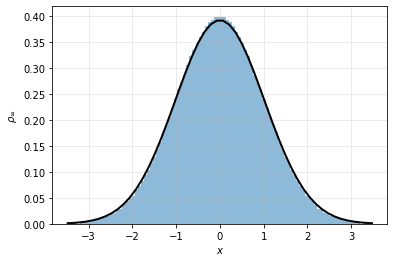

In [3]:
pgf_switch('off')
p_eq = density_estimation(X)
_ = plt.plot(np.linspace(min(X),max(X)),[p_eq([x]) for x in np.linspace(min(X),max(X))],color='k',lw=2)
_ = plt.hist(X,density=True,bins=100,alpha=0.5)
_ = plt.grid(alpha=0.3)
_ = plt.xlabel('$x$')
_ = plt.ylabel('$\\rho_{\infty}$')

In [4]:
X_s = X.reshape(N,1)

epsilon = 7.44e-05
d = 1.00


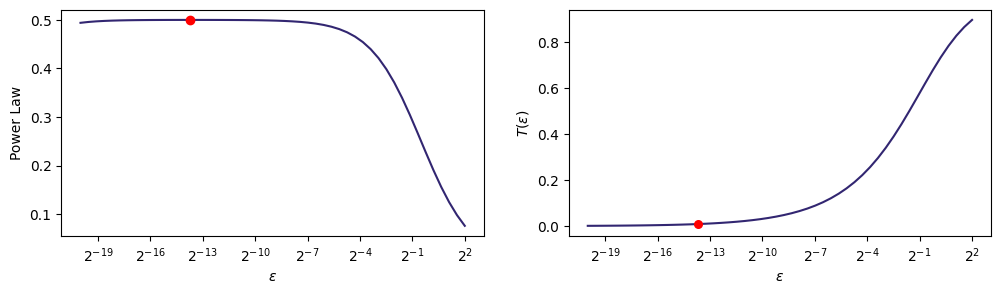

In [5]:
epsilon, d = bandwidth_search(X_s,plot=True,verbose=True)

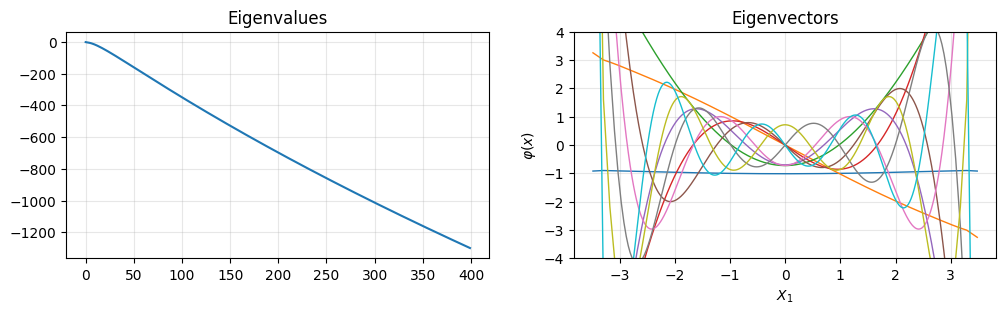

In [6]:
l, phi,L_e, U = KNPGenerator(X_s,M=400,plot=True,return_extra=True)
phi_1 = np.linalg.pinv(phi)

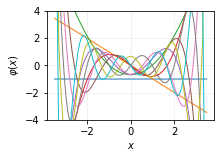

In [7]:
setting = 'off'
pgf_switch(setting)
plt.figure(figsize=(3,2))
for i in range(10):
    plt.plot(X_s,phi[:,i],lw=1)
plt.ylim(-4,4)
plt.grid(alpha=0.2)
plt.xlabel('$x$')
plt.ylabel('$\\varphi(x)$')

if setting == 'on':
    _ = plt.savefig(figures_route + '1dOUeigenfunct.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

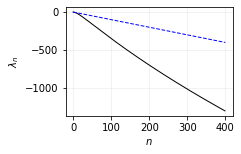

In [8]:
setting = 'off'
pgf_switch(setting)
plt.figure(figsize=(3,2))
plt.plot(l,color='k',lw=1)
plt.xlabel('$n$')
plt.ylabel('$\\lambda_n$')
plt.plot([0,400],[0,-400],color='b',ls='--',lw=1)
plt.grid(alpha=0.2)
if setting == 'on':
    _ = plt.savefig(figures_route + '1dOUeigenvalues.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

In [9]:
def Hermite(k,x,D):
    l_hermite = -(np.arange(0,k))
    phi_hermite = np.zeros((len(x),k))
    for ell in range(1,k+1):
        phi_hermite[:,ell-1] = (1/(factorial(ell-1)**0.5)) * eval_hermitenorm(ell-1,x*np.sqrt(1/D))
    return(l_hermite,phi_hermite)
D = 1
l_hermite, phi_hermite =  Hermite(k=120,x=X_s[:,0],D=D)
L = phi_hermite @ np.diag(l_hermite) @ np.linalg.pinv(phi_hermite)

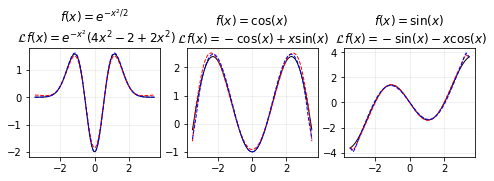

In [10]:
setting = 'off'
pgf_switch(setting)
fig,axs = plt.subplots(1,3,figsize=(8,2))

x = np.linspace(min(X_s),max(X_s),100)

Y = np.exp(-X_s[:,0]**2)
c_coef = (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
axs[0].set_title("$f(x) =e^{-x^2/2} $ \n $\mathcal{L}f(x) = e^{-x^2}(4x^2-2 + 2x^2) $")
axs[0].plot(x, D*np.exp(-x**2)*(4*x**2-2) + 2*x**2*np.exp(-x**2),color='k',lw=1)
axs[0].plot(X_s,np.sum((c_coef*l) * phi,axis=1),color='r',lw=1,ls='--')
axs[0].plot(X_s,np.sum((c_coef1*l) * phi,axis=1),color='b',lw=1,ls='--')
axs[0].grid(alpha=0.25)

Y = np.cos(X_s[:,0])
c_coef =  (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
axs[1].set_title("$f(x) =\cos(x) $ \n $\mathcal{L}f(x) = -\cos(x)+x\sin(x) $")
axs[1].plot(x,-D*np.cos(x) + x * np.sin(x),color='k',lw=1)
axs[1].plot(X_s,np.sum((c_coef*l) * phi,axis=1),color='r',lw=1,ls='--')
axs[1].plot(X_s,np.sum((c_coef1*l) * phi,axis=1),color='b',lw=1,ls='--')

axs[1].grid(alpha=0.25)

Y = np.sin(X_s[:,0])
c_coef = (D) * phi_1 @ Y
c_coef1 =  (D/N)* Y@U
axs[2].set_title("$f(x) =\sin(x) $ \n $\mathcal{L}f(x) = -\sin(x)-x\cos(x) $")
axs[2].plot(x,-D*np.sin(x) - x * np.cos(x),color='k',lw=1,label='Analytic Solution')
axs[2].plot(X_s,np.sum((c_coef*l) * phi,axis=1),color='r',label='Computing coefficients using the inverse',lw=1,ls='--')
axs[2].plot(X_s,np.sum((c_coef1*l) * phi,axis=1),color='b',label='Computing coefficients using orthonormality',lw=1,ls='--')
axs[2].grid(alpha=0.25)
# axs[2].legend(loc=(-1.3,-0.5))
if setting == 'on':
    _ = plt.savefig('Figures/1dOUtest.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

(-3.5, 3.5)

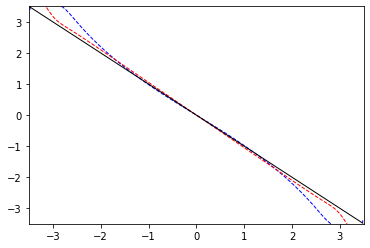

In [11]:
setting = 'off'
pgf_switch(setting)
Y = X_s[:,0]
c_coef =  (D/N)* Y@U
c_coef1 = (D) * phi_1 @ Y
plt.plot(np.sort(X_s,axis=0),np.sum((c_coef*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='b',lw=1,ls='--')
plt.plot(np.sort(X_s,axis=0),np.sum((c_coef1*l) * phi,axis=1)[np.argsort(X_s,axis=0)],color='r',lw=1,ls='--')
plt.plot(x, - x ,color='k',lw=1)
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)

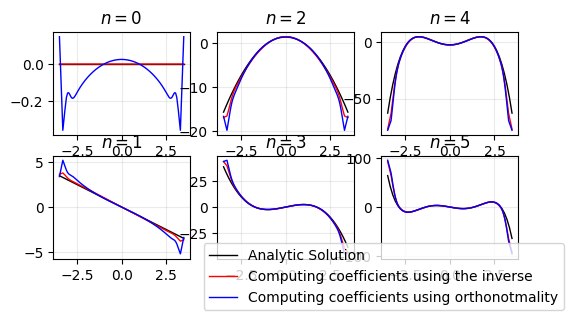

In [12]:
fig,axs = plt.subplots(2,3,figsize=(6,3),dpi=100)

for i,elle in enumerate([1,2,3,4,5,6]):
    Y = (1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,X_s[:,0]*np.sqrt(1/D))
    c_coef = (D) * phi_1 @ Y
    c_coef1 =  (D/N)* Y@U
    x = np.linspace(min(X_s),max(X_s))
    
    axs[i%2,int(i / 2)].set_title(f"$n = {i}$")
    axs[i%2,int(i / 2)].plot(x,-(elle-1)*(1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,x*np.sqrt(1/D)),
                             color='k',lw=1,label='Analytic Solution')
    axs[i%2,int(i / 2)].plot(X_s,np.sum((c_coef*l) * phi,axis=1),
                             color='r',label='Computing coefficients using the inverse',lw=1)
    axs[i%2,int(i / 2)].plot(X_s,np.sum((c_coef1*l) * phi,axis=1),
                             color='b',label='Computing coefficients using orthonotmality',lw=1)
    axs[i%2,int(i / 2)].grid(alpha=0.25)
#     if elle == 1:
#         axs[i%2,int(i / 2)].set_ylim(-1e-1,1e-1)
axs[1,2].legend(loc=(-1.3,-0.5))

# Push-forward of a initial density $p_0(x)$

### 1. Estimate the initial condition $c_i(0)$ as $$\hat{c}_i(0)=\frac{1}{N}\sum_{j=1}^N \frac{p_0(x_j)}{\hat{p}_{\text{eq}}(x_j)}\varphi_i(x_j) $$

In [13]:
p_0 = np.vectorize(lambda x: sp.stats.expon.pdf(x,0))
p_eq = density_estimation(X_s)
rho_eq = np.vectorize(lambda x: p_eq(x)[0])
c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)
init = 0
tf = 2
Nt = 100
tarray = np.linspace(0,tf,Nt)
csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0

### 3. Using $M$ modes estimate the density  as $$\hat{p}(x,t) =\hat{p}_{\text{eq}}(x) \sum_{i=0}^M \hat{c}_i(t)\varphi_i(x)$$

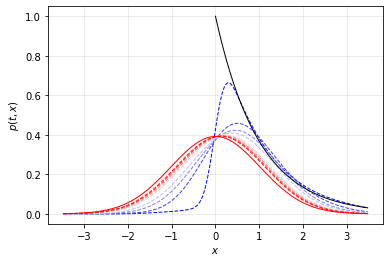

In [14]:
X_sort = np.sort(np.ravel(X_s))
N = len(X_s)
dx = np.diff(X_sort)
# plt.figure(figsize=(10,5),dpi=100)
for t in np.arange(1,100,12):
    est_density = p_eq(X_s.T)* np.sum(phi * csol[t],axis=1)

    est_density=est_density[np.argsort(np.ravel(X_s))]
    cum = trapz(x=X_sort,y= est_density.T)
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.bwr(t/100),ls='--')
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_eq(np.linspace(min(X_s),max(X_s),100).T),
         color='r',lw=1)
plt.plot(np.linspace(0,max(X_s),100),p_0(np.linspace(0,max(X_s),100)),
         color='k',lw=1)
plt.xlabel('$x$')
plt.ylabel('$p(t,x)$')
plt.grid(alpha=0.3)

Theoretical result
    $$p(x,t) = \int \frac{1}{\sqrt{{2\pi D(1-e^{-2t})}}} \exp{\left(-\frac{(x-x_0e^{-t})^2}{2D(1-e^{-2t}) } \right)}p_0(x_0)dx_0$$

In [15]:
p_transition = lambda x0,x,t: sp.stats.norm.pdf(x,loc=x0*np.exp(-t),scale = (1-np.exp(-2*t))*D)*p_0(x0)

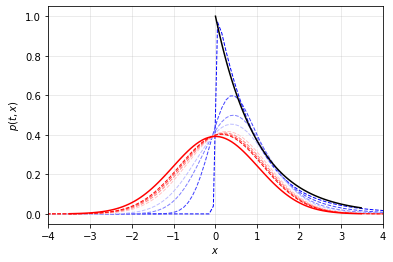

In [16]:
for t in np.linspace(0,tf,Nt)[np.arange(1,100,12)]:
    N = 200
    x = np.linspace(-10,10,N)
    x0 = np.linspace(-10,10,N)
    pxt = np.zeros_like(x)
    for i in range(N):
        pxt[i] = trapz(x=x0,y=p_transition(x0,x[i],t))
    plt.plot(x,pxt/trapz(x=x,y=pxt) ,color=plt.cm.bwr(t/2),lw=1,ls='--')
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_eq(np.linspace(min(X_s),max(X_s),100).T),
         color='r')
plt.plot(np.linspace(0,max(X_s),100),p_0(np.linspace(0,max(X_s),100)),
         color='k')
plt.xlabel('$x$')
plt.ylabel('$p(t,x)$')
plt.xlim(-4,4)
plt.grid(alpha=0.3)

# Push-forward of obserbable $f(x)$


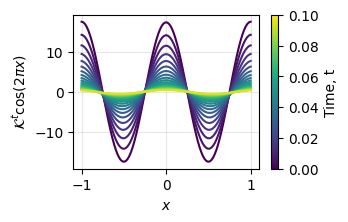

In [30]:
setting = 'off'
pgf_switch(setting)

Koopman = np.zeros((20,100))
for i,y in enumerate(np.linspace(-1,1,100)):
    p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,loc=y,scale=0.01))
    p_eq = density_estimation(X_s)
    rho_eq = np.vectorize(lambda x: p_eq(x)[0])
    c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)
    init = 0
    tf = 0.1
    Nt = 20
    tarray = np.linspace(0,tf,Nt)
    csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0

   
    f = np.cos(X_s[:,0]*2*np.pi)
    a = (1/N)*(f @ phi)
    Koopman[:,i] = csol @ a
fig,ax = plt.subplots(1,1,figsize=(3,2))
for j in range(Koopman.shape[0]):
    ax.plot(np.linspace(-1,1,100), Koopman[j,:],color=plt.cm.viridis(j/(Koopman.shape[0])))
ax.grid(alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$\mathcal{K}^{t}\cos(2\pi x)$')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,tf), cmap=plt.cm.viridis),ax= ax,label='Time, t')
if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUKoopman_cos.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

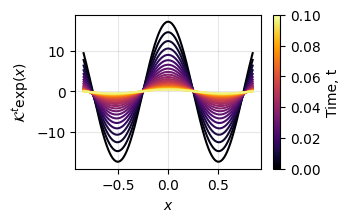

In [42]:
setting = 'off'
pgf_switch(setting)
plt.style.use('default')
# x_space = np.linspace(-2,2,100)
x_space = X_s[800:3200,0]

Koopman = np.zeros((25,len(x_space)))
p_eq = density_estimation(X_s)
for i,y in enumerate(x_space):    
    c_0 = phi[800+i,:]
    init = 0
    tf = 0.1
    Nt = 25
    tarray = np.linspace(0,tf,Nt)
    csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0

   
    f = np.cos(X_s[:,0]*2*np.pi)
    a = (1/N)*(f @ phi)
    Koopman[:,i] = csol @ a
fig,ax = plt.subplots(1,1,figsize=(3,2))
for j in range(Koopman.shape[0]):
    ax.plot(x_space, Koopman[j,:],color=plt.cm.inferno(j/(Koopman.shape[0])))
ax.grid(alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$\mathcal{K}^{t}\exp(x)$')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,tf), cmap=plt.cm.inferno),ax= ax,label='Time, t')
if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUKoopman_exp.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

In [43]:
setting = 'on'
pgf_switch(setting)

Koopman = np.zeros((25,100))
x_space = np.linspace(0,2,100)
for i,y in enumerate(x_space):
    p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,loc=y,scale=0.01))
    p_eq = density_estimation(X_s)
    rho_eq = np.vectorize(lambda x: p_eq(x)[0])
    c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)
    init = 0
    tf = 4
    Nt = 25
    tarray = np.linspace(0,tf,Nt)
    csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0

   
    f = np.exp(X_s[:,0])
    a = (1/N)*(f @ phi)
    Koopman[:,i] = csol @ a
fig,ax = plt.subplots(1,1,figsize=(3,2))
for j in range(Koopman.shape[0]):
    ax.plot(x_space, Koopman[j,:],color=plt.cm.inferno(j/(Koopman.shape[0])))
ax.grid(alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$\mathcal{K}^{t}\exp(x)$')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,tf), cmap=plt.cm.inferno),ax= ax,label='Time, t')
if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUKoopman_exp9.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

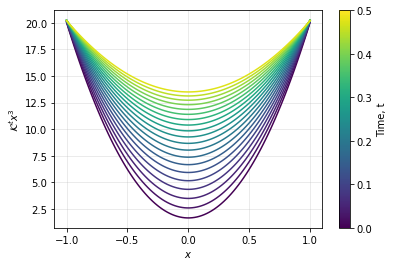

In [19]:
setting = 'off'
pgf_switch(setting)

Koopman = np.zeros((20,100))
for i,y in enumerate(np.linspace(-1,1,100)):
    p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,loc=y,scale=0.01))
    p_eq = density_estimation(X_s)
    rho_eq = np.vectorize(lambda x: p_eq(x)[0])
    c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s))) * phi,axis=0)
    init = 0
    tf = 0.5
    Nt = 20
    tarray = np.linspace(0,tf,Nt)
    csol = np.exp(tarray[:,None] * l[None,:] * D ) * c_0
    f = X_s[:,0]**2
    a = (1/N)*(f @ phi)
    Koopman[:,i] = csol @ a
fig,ax = plt.subplots(1,1)
for j in range(Koopman.shape[0]):
    ax.plot(np.linspace(-1,1,100), Koopman[j,:],color=plt.cm.viridis(j/(Koopman.shape[0])))
ax.grid(alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$\mathcal{K}^{t}x^3$')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,tf), cmap=plt.cm.viridis),ax= ax,label='Time, t')

CPU times: user 891 ms, sys: 1.03 s, total: 1.92 s
Wall time: 981 ms


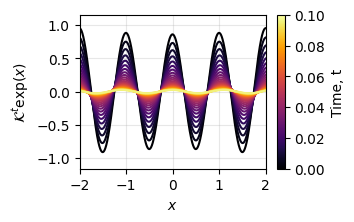

In [225]:
%%time
setting = 'off'
pgf_switch(setting)
plt.style.use('default')
Koopman = np.zeros((25,len(X_s)))
# x_space = np.linspace(-2,2,100)
x_space = X_s
p_eq = density_estimation(X_s)
rho_eq = np.vectorize(lambda x: p_eq(x)[0])

init = 0
tf = 0.1
Nt = 25
tarray = np.linspace(0,tf,Nt)    
c_0 = phi.T
eigen_exp = np.exp(tarray[:,None] * l[None,:] * D )
csol2 = (eigen_exp[...,None]*c_0[None,...]) #Fine 
a = (1/len(X_s))*(f @ phi)
Koopman = np.tensordot(csol2,a,axes=(1,0))
    
fig,ax = plt.subplots(1,1,figsize=(3,2))
for j in range(Koopman.shape[0]):
    ax.plot(x_space, Koopman[j,:],color=plt.cm.inferno(j/(Koopman.shape[0])))
ax.set_xlim(-2,2)
ax.grid(alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$\mathcal{K}^{t}\exp(x)$')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,tf), cmap=plt.cm.inferno),ax= ax,label='Time, t')
if setting == 'on':
    _ = plt.savefig(figures_route +'1dOUKoopman_exp.pgf', bbox_inches='tight', pad_inches=0)
    _ = plt.close()

In [228]:
Koopman.shape

(25, 4000)

In [189]:
csol[...,0]@a

array([-2.8703888 , -2.54550594, -2.29193046, -2.09338605, -1.93599452,
       -1.80947397, -1.70643001, -1.62152803, -1.55086371, -1.49152856,
       -1.44131733, -1.3985306 , -1.36183989, -1.33019385, -1.30275172,
       -1.27883518, -1.25789271, -1.23947296, -1.22320424, -1.20877885,
       -1.19594067, -1.18447551, -1.1742033 , -1.16497201, -1.15665262])

In [192]:
Koopman[0,:]

array([-1.05595703, -0.27436793,  0.49008001, ...,  0.49008001,
       -0.27436793, -1.05595703])

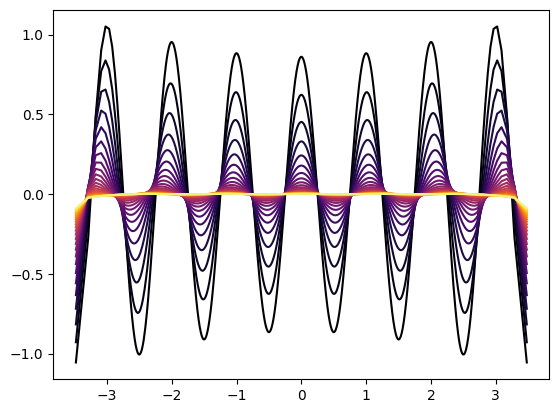

In [216]:
for j in range(Koopman.shape[0]):
    plt.plot(x_space, Koopman[j,:],color=plt.cm.inferno(j/(Koopman.shape[0])))